<center><h2>ALTeGraD 2023<br>Lab Session 3: Transfer learning for NLP</h2> 24 / 10 / 2023<br> Dr. G. Shang, H. Abdine<br><br>


<b>Student name:</b> Benjamin Lapostolle

</center>

<br><br>
In this lab we will:
* Implement and pretrain a language model with transformer architecture.
* Use the pretrained model (transfer learning) to perform a sentiment analysis task which consists of classifying some books reviews into positive and negative ones.
* Compare the performance of the pretrained model to a model trained from scratch.
 <br>

<b>The deadline for this lab is October 31, 2023 11:59 PM.</b> More details about the submission and the architecture for this lab can be found in the handout PDF.

In [1]:
import math
import numpy as np

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
print(device)

cuda


### The Model

In [3]:
class TransformerModel(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        '''
        ntokens: the size of vocabulary
        nhid: the hidden dimension of the model.
        We assume that embedding_dim = nhid
        nlayers: the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        nhead: the number of heads in the multiheadattention models
        dropout: the dropout value
         '''
        self.model_type = "Transformer"
        self.encoder = nn.Embedding(num_embeddings=ntoken, embedding_dim=nhid) # fill me, nhid = the dim_embed
        self.pos_encoder = PositionalEncoding(nhid) #fill me, the PositionalEncoding class is implemented in the next cell
        encoder_layers = nn.TransformerEncoderLayer(d_model=nhid, nhead=nhead, dim_feedforward=nhid) #fill me we assume nhid = d_model = dim_feedforward
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=encoder_layers, num_layers=nlayers) #fill me
        self.nhid = nhid
        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.nhid)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        return output


class ClassificationHead(nn.Module):
    def __init__(self, nhid, nclasses):
        super(ClassificationHead, self).__init__()
        self.decoder = nn.Linear(nhid, nclasses)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        output = self.decoder(src)
        return output

class Model(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, nclasses, dropout=0.5):
        super(Model, self).__init__()
        self.base = TransformerModel(ntoken, nhead, nhid, nlayers, dropout)
        self.classifier = ClassificationHead(nhid, nclasses)

    def forward(self, src, src_mask):
        # base model
        x = self.base(src, src_mask)
        # classifier model
        output = self.classifier(x)
        return output

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, nhid, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, nhid)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, nhid, 2).float() * (-math.log(10000.0) / nhid)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)

Let's verify if our model works, by applying one inference step

In [5]:
ntokens = 100 # the size of vocabulary
nhid = 200  # hidden dimension
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)
dummy_input = torch.tensor([[2, 6, 2, 5, 43, 21]]).to(device)
src_mask = model.base.generate_square_subsequent_mask(1).to(device)
out = model.forward(dummy_input, src_mask)

print(out.shape) # is it the right shape?

c:\Users\benja\anaconda3\envs\altegrad\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([1, 6, 100])


We obtain the shape $[1,6,100]$. 1 corresponds to a batch, 6 corresponds to the number of words we predicted and 100 corresponds to the number of classes, which is equal to the size of the vocabulary here so 100.

## Vocabulary and Tokenization

In [6]:
#!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
#!head -5 dict.txt

path_vocab = r"C:\Users\benja\Documents\MVA\P1\Altegrad\TP3\dict.txt"


with open(path_vocab, 'r') as R:
    print(R.readlines()[:5])

['▁d 1\n', 'es 1\n', '▁l 1\n', 'en 1\n', 'on 1\n']


In [7]:
path_vocab = r"C:\Users\benja\Documents\MVA\P1\Altegrad\TP3\dict.txt"

token2ind = {"<sos>": 0, "<pad>": 1, "<eos>": 2, "<oov>": 3} # the 4 first indices are reserved to special tokens
with open(path_vocab, "r") as f:
    for idx, line in enumerate(f):
        word = line.split()[0].strip()
        token2ind[word] = idx + 4 #fill me

ind2token = {idx: word for word, idx in token2ind.items()} #fill me

print(ind2token[1111], token2ind[ind2token[1111]])

▁trop 1111


### Data Loader


In [8]:
import numpy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset


class Dataset(Dataset):
    def __init__(
        self,
        path_documents,
        path_labels=None,
        token2ind={},
        max_len=512,
        task="language_modeling",
    ):
        self.task = task
        self.max_len = max_len
        self.token2ind = token2ind
        self.documents = []
        self.labels = []
        with open(path_documents, "r") as f1:
            for line in f1:
                self.documents.append(line.strip())
        if task == "classification":
            with open(path_labels, "r") as f1:
                for line in f1:
                    self.labels.append(int(line.strip()))
            assert len(self.labels) == len(self.documents)

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        sequence = self.documents[index].split()
        if len(sequence) > self.max_len - 1:
            sequence = sequence[: self.max_len - 1]
        source_sequence = [self.token2ind['<sos>']]#fill me (constract the input sequence using token2ind, sequence and special tokens)
        for token in sequence:#do not forget to use the <oov> when the token in the data studied is not in our defined vocab
                if token in token2ind.keys():
                    source_sequence.append(self.token2ind[token])
                else:
                    source_sequence.append(self.token2ind['<oov>'])
                    
        if self.task == "language_modeling":
            target = source_sequence[1:]
            target.append(self.token2ind["<eos>"])
        elif self.task == "classification":
            target = [self.labels[index]]
        sample = {
            "source_sequence": torch.tensor(source_sequence),
            "target": torch.tensor(target),
        }
        return sample


def MyCollator(batch):
    source_sequences = pad_sequence(
        #we use padding to match the length of the sequences in the same batch
        [sample["source_sequence"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    target = pad_sequence(
        [sample["target"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    return source_sequences, target.reshape(-1)


def get_loader(
    path_documents,
    path_labels=None,
    token2ind={},
    max_len=512,
    batch_size=32,
    task="language_modeling",
):
    dataset = Dataset(
        path_documents,
        path_labels=path_labels,
        token2ind=token2ind,
        max_len=512,
        task=task,
    )
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=MyCollator,
        pin_memory=True,
        drop_last=True,
    )
    return data_loader

## The Training

In [9]:
def train(
    path_data_train,
    path_labels_train=None,
    path_data_valid=None,
    save_interval=-1,
    log_interval=5,
    task="language_modeling",
    batch_size=32,
):
    model.train()
    total_loss = 0.0
    ntokens = len(token2ind)
    data_loader = get_loader(
        path_data_train,
        path_labels_train,
        token2ind,
        task=task,
        batch_size=batch_size,
    )
    
    losses = []
    #criterion = torch.nn.CrossEntropyLoss() #defined globally in next cells
    for idx, data in enumerate(data_loader): #step 1
        optimizer.zero_grad()
        src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(
            device
        )
        input = data[0].to(device)
        output = model(input, src_mask) #step 2
        #print('rax output', output.shape)
        if task == 'classification':
            #last vector only, because we want to do sentiment analysis
            output = output[-1,:,:]
            #print('output2', output.shape)
        output = output.view(-1, output.shape[-1])
        target =  data[1] #fill me
        target = target.to(device)
        #fill me, Cross entropy check next cells #check if we need to flatten 
        #fill me step 3
        #print(input.shape, output.shape, target.shape, '11111')
        loss =  criterion(output, target)   
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # prevent exploding gradient
        #fill me step 4
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if idx % log_interval == 0 and idx > 0:
            cur_loss = total_loss / log_interval
            print(
                "| epoch {:3d} | {:5d}/{:5d} steps | "
                "loss {:5.5f} | ppl {:8.3f}".format(
                    epoch, idx, len(data_loader), cur_loss, math.exp(cur_loss),
                )
            )
            losses.append(cur_loss)
            total_loss = 0
    return losses

In [10]:
len(token2ind.keys())

50001

In [44]:
ntokens = len(token2ind.keys())#fill me # the size of vocabulary
nhid = 200  # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

nclasses = 2 # for classification task only

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)

c:\Users\benja\anaconda3\envs\altegrad\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [45]:
# optimization paramerters

criterion = nn.CrossEntropyLoss(ignore_index=token2ind['<pad>'])
lr = 0.0003  # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [46]:
#!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
path_data_train = r"C:\Users\benja\Documents\MVA\P1\Altegrad\TP3\pretraining_subset.txt"

In [47]:
#pretraining on a tiny subset
log_interval = 500
epochs = 2
for epoch in range(1, epochs + 1): #5
    train(
        path_data_train,
        save_interval=-1,
        task= "language_modeling", # fill me
        batch_size=16,
        log_interval=log_interval,
    )

| epoch   1 |   500/ 3125 steps | loss 7.11124 | ppl 1225.666
| epoch   1 |  1000/ 3125 steps | loss 5.26273 | ppl  193.007
| epoch   1 |  1500/ 3125 steps | loss 4.08292 | ppl   59.318
| epoch   1 |  2000/ 3125 steps | loss 3.01488 | ppl   20.387
| epoch   1 |  2500/ 3125 steps | loss 2.26374 | ppl    9.619
| epoch   1 |  3000/ 3125 steps | loss 1.73666 | ppl    5.678
| epoch   2 |   500/ 3125 steps | loss 1.11823 | ppl    3.059
| epoch   2 |  1000/ 3125 steps | loss 0.92408 | ppl    2.520
| epoch   2 |  1500/ 3125 steps | loss 0.77302 | ppl    2.166
| epoch   2 |  2000/ 3125 steps | loss 0.66263 | ppl    1.940
| epoch   2 |  2500/ 3125 steps | loss 0.56617 | ppl    1.762
| epoch   2 |  3000/ 3125 steps | loss 0.50207 | ppl    1.652


## Text Generation


In [14]:
#!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt

model = Model(ntokens, nhead, nhid, nlayers, ntokens).to(device)

#load the checkpoint
path_weigths = r"C:\Users\benja\Documents\MVA\P1\Altegrad\TP3\pretrained_model_4layers.pt"
checkpoint = torch.load(path_weigths)
#load state dict
model.load_state_dict(checkpoint['model_state_dict'])

c:\Users\benja\anaconda3\envs\altegrad\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [15]:
# !pip install sentencepiece   # uncomment this if you are using google colab
#!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model

import sentencepiece as spm

s = spm.SentencePieceProcessor(model_file=r"C:\Users\benja\Documents\MVA\P1\Altegrad\TP3\sentencepiece.french.model") #load sentencepiece model

#examples
encoded = s.encode_as_pieces("Bonjour les amis!")
decoded = s.decode_pieces(encoded)
print(encoded)
print(decoded)

['▁Bonjour', '▁les', '▁amis', '!']
Bonjour les amis!


In [16]:
def infer_next_token(sent):
    model.eval()
    sent_pieces = s.encode_as_pieces(sent)
    source = [token2ind['<sos>']] + [token2ind[el] for el in sent_pieces] # list of tokens, here we assume we won't have <oov>
    source = torch.tensor(source).to(device)
    source = source.reshape(-1, 1)
    src_mask = model.base.generate_square_subsequent_mask(source.size(0)).to(device)
    out = model(source, src_mask)
    next_token_ind = torch.argmax(F.softmax(out, dim=2)[-1,0,:]) #argmax(softmax(output))#see the size of the output of the model in this task, if it is size vocabulary then the next token is the argmax of the softmax of the output#fill me
    return next_token_ind, out

def infer_next_tokens(sent, max_len=50):
    # to be implemented
    predicted_sent, source, last_predicted_idx = sent, s.encode_as_pieces(sent), -1 #last_predicted_index is used to check if the previous predicted token is a <eos>
    while len(source) < max_len and last_predicted_idx != 2: #2 is the index of <eos> in our tokenization of the vocabulary 
        last_predicted_idx, _ = infer_next_token(predicted_sent)
        source.append(ind2token[last_predicted_idx.item()])
        predicted_sent = s.decode_pieces(source)
    return predicted_sent

In [17]:
sent = "Bonjour les"
infer_next_tokens(sent)

'Bonjour les gens qui ont fait des choses.<eos>'

### Supervised task

In [43]:
#!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
#!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
#!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.review.spm
#!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.label

path_data_train = r"C:\Users\benja\Documents\MVA\P1\Altegrad\TP3\train.review.spm"
path_labels_train = r"C:\Users\benja\Documents\MVA\P1\Altegrad\TP3\train.label"

path_data_valid = r"C:\Users\benja\Documents\MVA\P1\Altegrad\TP3\test.review.spm"
path_labels_valid = r"C:\Users\benja\Documents\MVA\P1\Altegrad\TP3\test.label"

In [32]:
# a function to evaluate the validation accuracy of the model.
def evaluate_accuracy(data_loader):
    #to be implemented
    model.eval()
    accuracies = []
    for idx, data in enumerate(data_loader):
        src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(
            device
        )
        input = data[0].to(device)
        output = model(input, src_mask)[-1,:,:].to(torch.device("cpu"))
        predictions = torch.argmax(F.softmax(output, dim = 1), dim = 1)
        targets =  data[1]
        correct_predictions = (predictions == targets).sum().item()
        accuracy = correct_predictions / len(targets)
        accuracies.append(accuracy)
    
    return np.array(accuracies).sum() / len(accuracies)
        

In [20]:
#save the base model to be loaded later in the fine-tuning phase
torch.save({"model_state_dict": model.base.state_dict(),}, "pretrained_model_4layers_no_class_head.pt")

In [36]:
from_scratch_settings = [True, False]

from_scratch_valid_acc = []
pretrained_valid_acc = []
lr = 0.0001

for from_scratch in from_scratch_settings:
    model = Model(ntokens, nhead, nhid, nlayers, 2, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if not from_scratch:
        print("=====PRETRAINED MODEL======")
        #load checkpoint
        checkpoint = torch.load("pretrained_model_4layers_no_class_head.pt")
        #load state dict
        model.base.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("=====Trainig FROM SCRATCH======")
    epochs = 15
    for epoch in range(1, epochs + 1):
        train(
            path_data_train,
            path_labels_train,
            save_interval=-1,
            task='classification',
            batch_size=8,
            log_interval=50,
        )
        acc = evaluate_accuracy(
            get_loader(
                path_data_valid,
                path_labels_valid,
                token2ind=token2ind,
                batch_size=20,
                task='classification',
            )
        )
        if from_scratch:
            from_scratch_valid_acc.append(acc)
        else:
            pretrained_valid_acc.append(acc)
    print()

=====Trainig FROM SCRATCH======
| epoch   1 |    50/  200 steps | loss 0.81914 | ppl    2.269
| epoch   1 |   100/  200 steps | loss 0.70112 | ppl    2.016
| epoch   1 |   150/  200 steps | loss 0.71595 | ppl    2.046
| epoch   2 |    50/  200 steps | loss 0.71600 | ppl    2.046
| epoch   2 |   100/  200 steps | loss 0.70636 | ppl    2.027
| epoch   2 |   150/  200 steps | loss 0.70208 | ppl    2.018
| epoch   3 |    50/  200 steps | loss 0.69773 | ppl    2.009
| epoch   3 |   100/  200 steps | loss 0.63428 | ppl    1.886
| epoch   3 |   150/  200 steps | loss 0.60084 | ppl    1.824
| epoch   4 |    50/  200 steps | loss 0.41552 | ppl    1.515
| epoch   4 |   100/  200 steps | loss 0.35323 | ppl    1.424
| epoch   4 |   150/  200 steps | loss 0.30195 | ppl    1.352
| epoch   5 |    50/  200 steps | loss 0.08260 | ppl    1.086
| epoch   5 |   100/  200 steps | loss 0.05996 | ppl    1.062
| epoch   5 |   150/  200 steps | loss 0.13188 | ppl    1.141
| epoch   6 |    50/  200 steps | loss

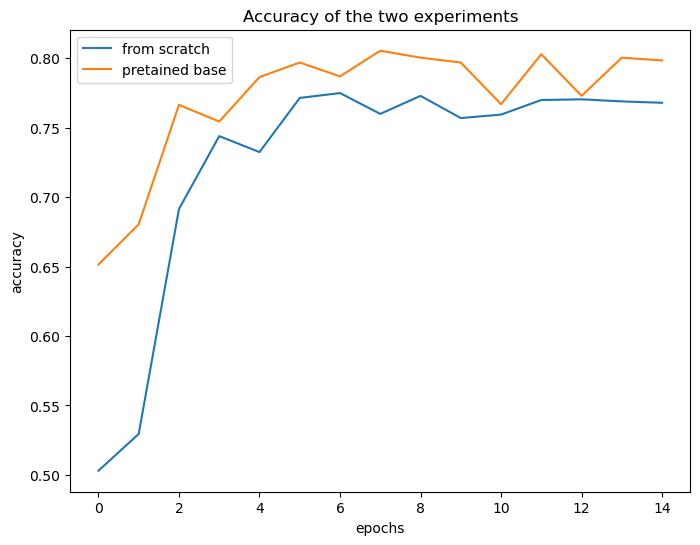

In [41]:
#Visualize the accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(from_scratch_valid_acc, label='from scratch')
plt.plot(pretrained_valid_acc, label='pretained base')

# Add labels, title, and legend
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy of the two experiments')
plt.legend()

# Display the plot
plt.show()

In [38]:
pretrained_valid_acc

[0.6515000000000001,
 0.6805,
 0.7665,
 0.7544999999999998,
 0.7865000000000002,
 0.7970000000000002,
 0.787,
 0.8055,
 0.8005,
 0.7969999999999999,
 0.7669999999999999,
 0.8029999999999999,
 0.7729999999999998,
 0.8005000000000001,
 0.7985000000000002]